<a href="https://colab.research.google.com/github/Unicorn02/Python_project/blob/main/Copy_of_IntroNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/bin/bash: line 1: nvidia-smi: command not found
Using device: cpu


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

Epoch 0/4
-----
train Loss: 1.0853 Acc: 0.5309
test Loss: 1.2967 Acc: 0.1474
Epoch 1/4
-----
train Loss: 0.9746 Acc: 0.5309
test Loss: 1.2308 Acc: 0.2000
Epoch 2/4
-----
train Loss: 0.8604 Acc: 0.6173
test Loss: 1.1065 Acc: 0.3579
Epoch 3/4
-----
train Loss: 0.7427 Acc: 0.7160
test Loss: 1.0516 Acc: 0.4526
Epoch 4/4
-----
train Loss: 0.6373 Acc: 0.7654
test Loss: 0.9635 Acc: 0.5158
Training complete in 6m 46s
Best test Acc: 0.5158
Accuracy of the network on the test images: 51.58%


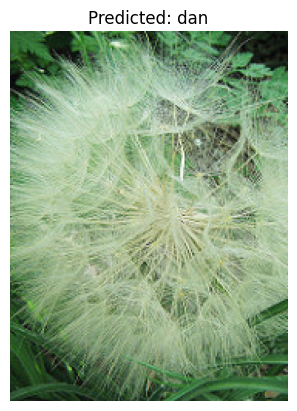

In [ ]:
# Install necessary packages
!pip install tensorflow transformers psutil tensorflow-cpu
!pip install matplotlib

import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from glob import glob
import torch
torch.__version__

import torch
torch.cuda.is_available

!nvidia-smi

# Check for GPU availability otherwise use CPU
my_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {my_device}')

# Define data transformations for training and validation datasets
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Specify the directory containing the dataset
data_dir = r"/content/drive/MyDrive/flower_photos (1)/flower_photos/dataset/spare"

# Validate the data directory path
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The specified data directory does not exist: {data_dir}")

# Check for the existence of 'train' and 'test' subdirectories
for sub_dir in ['train', 'test']:
    full_path = os.path.join(data_dir, sub_dir)
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"The subdirectory does not exist: {full_path}")

# Create datasets using ImageFolder and apply the defined transformations
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), image_transforms[x])
                  for x in ['train', 'test']}

# Create dataloaders for loading the datasets in batches
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'test']}

# Get the sizes of the datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# Get the class names from the training dataset
class_names = image_datasets['train'].classes

# Load a pre-trained ResNet-50 model
model_ft = models.resnet50(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the available device (GPU or CPU)
model_ft = model_ft.to(my_device)

# Define the loss function and optimizer Stochastic Gradient Descent
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 5)

        for step in ['train', 'test']:
            if step == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[step]:
                inputs = inputs.to(my_device)
                labels = labels.to(my_device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(step == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if step == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if step == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[step]
            epoch_acc = running_corrects.double() / dataset_sizes[step]

            print(f'{step} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if step == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

# Train the model with the defined parameters
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

# Evaluate the model on the test dataset
model_ft.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(my_device)
        labels = labels.to(my_device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

# Function for inference on a single image
def predict_image(my_image_path, model):
    model.eval()
    img = Image.open(my_image_path)
    transform = image_transforms['test']
    img = transform(img).unsqueeze(0).to(my_device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

    return class_names[preds[0]]

# Example of predicting the class of a single image
#my_image_pathDan = '/content/drive/MyDrive/flower_photos (1)/flower_photos/dataset/spare/train/dan/10443973_aeb97513fc_m.jpg'
#my_image_pathLips= '/content/drive/MyDrive/flower_photos (1)/flower_photos/dataset/spare/train/lips/100930342_92e8746431_n.jpg'
#my_image_pathSun = '/content/drive/MyDrive/flower_photos (1)/flower_photos/dataset/spare/train/sun/8929213942_5544191250_n.jpg'
#my_image_path= ("dan",image_pathDan, "lips",image_pathLips, "sun",image_pathSun)
my_image_path='/content/drive/MyDrive/flower_photos (1)/flower_photos/dataset/spare/train/dan/10443973_aeb97513fc_m.jpg'
predicted_class = predict_image(my_image_path, model_ft)

# Display the image with the predicted class
def display_image_with_prediction(my_image_path, predicted_class):
    img = Image.open(my_image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

display_image_with_prediction(my_image_path, predicted_class)

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found
